In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx
import matplotlib.pyplot as plt
import tensorly


c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%run -i simulator.py

In [3]:
Ncommunities = 2

B                    = tf.convert_to_tensor(np.array([[0.3, 0.005], [0.005, 0.8]], dtype=np.float32))
initial_distribution = 0.5*tf.ones(2)

In [4]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

In [5]:
def d_spectral_tensorly(A, d):

    eigenvectors, eigenvalues, _ = tensorly.partial_svd(A.numpy(), n_eigenvecs=d)

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", tf.cast(eigenvectors_sort, dtype = tf.float32), tf.cast(tf.sqrt(tf.abs(eigenvalues_sort)), dtype = tf.float32))

In [6]:
d = 2
p, q, hatX = d_spectral_tensorly(A, d)

newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.15079838


In [42]:
def likelihood_evaluation(A, hatM):    

    hatM = tf.abs(hatM)
    # extract lower triangular matrix from A, M
    Lower = tf.linalg.band_part(tf.ones([N, N]), -1, 0) -  tf.linalg.band_part(tf.ones([N, N]), 0, 0)
    LowerA = tf.boolean_mask(A, Lower)
    LowerHatM = tf.boolean_mask(hatM, Lower)
    # select 0 entries of A
    maskA = (LowerA == tf.zeros_like(LowerA))
    # check if M has 0 or 1 entries
    maskM0 = (LowerHatM == tf.zeros_like(LowerHatM))
    maskM1 = (LowerHatM == tf.ones_like( LowerHatM))
    if (tf.math.reduce_any(maskM0 & ~maskA) | tf.math.reduce_any(maskM1 & maskA)):
        reject = True
        log_likelihood = np.nan
    else:
        reject = False
        edges = tf.concat([tf.math.log(1-tf.boolean_mask(LowerHatM,  maskA)), 
                           tf.math.log(  tf.boolean_mask(LowerHatM, ~maskA))], -1)
        log_likelihood = tf.reduce_sum(edges).numpy()
    return log_likelihood, reject

In [43]:
likelihood_evaluation(A, hatM)

(-144729.81, False)

## Importance Sampling

In [80]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

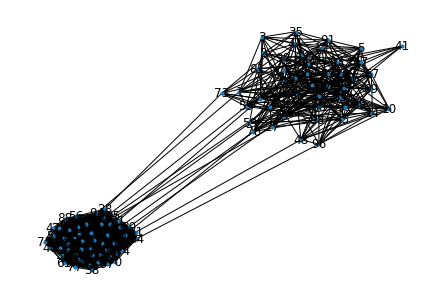

In [81]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [82]:
# true model
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [83]:
def importance_sampling(iterations, A, d):
    
    tildeX_list = []
    weight_list = []
    
    p, q, hatX = d_spectral_tensorly(A, d)
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)
    
    for i in range(iterations):

        tildeA = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(), dtype = tf.float32)

        p, q, tildeX = d_spectral_tensorly(tildeA, d)
        newsimulator = GRDPG(p, q, N)
        tildeXminus = tildeX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
        tildeM = tf.einsum("ik,jk->ij", tildeXminus, tildeX)

        weight = likelihood_evaluation(A, tildeM)[0] #+ likelihood_evaluation(tildeA, hatM)[0]
        
        tildeX_list.append(tildeX)
        weight_list.append(weight)

    return tildeX_list, weight_list


In [99]:
d = 2

iterations = 10000

tildeX_list, weight_list = importance_sampling(iterations, A, d)

(array([  13.,   92.,  443., 1459., 2660., 2829., 1806.,  583.,  108.,
           7.]),
 array([-145866.9 , -145840.39, -145813.89, -145787.38, -145760.86,
        -145734.34, -145707.84, -145681.33, -145654.81, -145628.31,
        -145601.8 ], dtype=float32),
 <BarContainer object of 10 artists>)

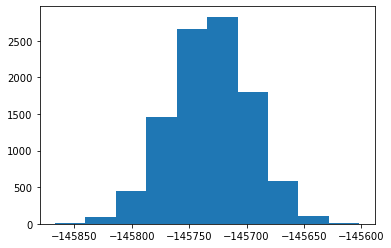

In [100]:
log_weight = np.array(weight_list)

plt.hist(log_weight)

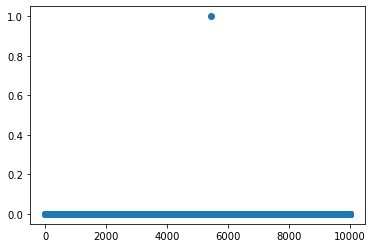

In [101]:
exp_weight = np.exp(log_weight-np.max(log_weight))

plt.scatter(np.linspace(0, exp_weight.shape[0]-1, exp_weight.shape[0]), exp_weight/np.sum(exp_weight))

In [105]:
tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-7.9993363e-03, -5.8107430e-01],
       [-2.9823680e-03, -5.0794458e-01],
       [-1.2145889e-02, -6.2758607e-01],
       ...,
       [-8.9102197e-01, -8.1610873e-05],
       [-8.9924705e-01, -4.8927651e-03],
       [-9.0213245e-01,  7.6143802e-03]], dtype=float32)>

In [106]:
p, q, hatX = d_spectral_tensorly(A, d)
hatX

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-0.0078262 ,  0.5690293 ],
       [-0.00741463,  0.4991521 ],
       [-0.00396803,  0.6448235 ],
       ...,
       [-0.8936389 , -0.00206482],
       [-0.9075901 ,  0.00381182],
       [-0.8690148 , -0.00242036]], dtype=float32)>

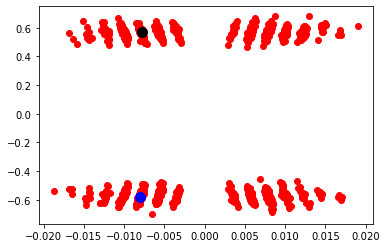

In [112]:
individual_index = 0

individual_0 = [tildeX_list[i][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, 1000):
    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

tildeX_max = tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

plt.scatter(tildeX_max[individual_index,0], tildeX_max[individual_index,1], color = "blue", s = 100)

plt.scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)


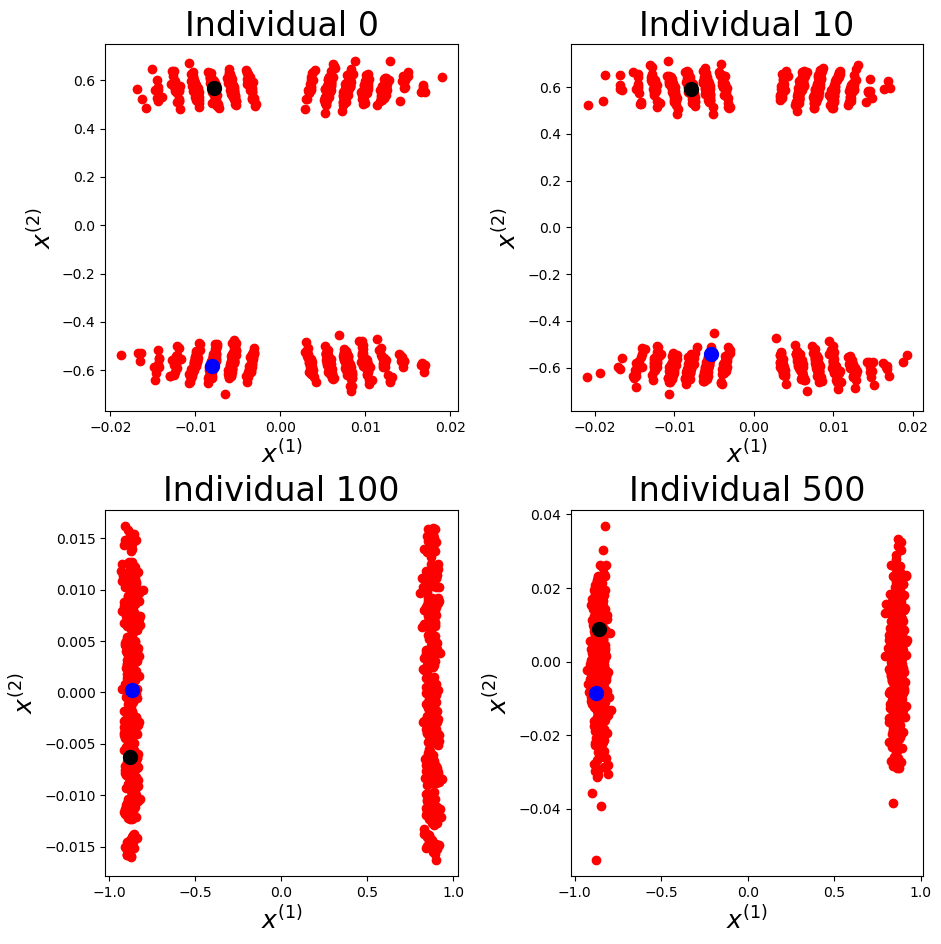

In [115]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 10), dpi = 100)
fig.tight_layout(pad=5)

ax[0,0].set_title("Individual 0", fontsize = 24)
ax[0,1].set_title("Individual 10", fontsize = 24)
ax[1,0].set_title("Individual 100", fontsize = 24)
ax[1,1].set_title("Individual 500", fontsize = 24)

ax[0,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[0,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,0].set_xlabel(r"$x^{(1)}$", fontsize = 18)
ax[1,1].set_xlabel(r"$x^{(1)}$", fontsize = 18)

ax[0,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[0,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,0].set_ylabel(r"$x^{(2)}$", fontsize = 18)
ax[1,1].set_ylabel(r"$x^{(2)}$", fontsize = 18)


individual_index = 0

individual_0 = [tildeX_list[i][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, 1000):
    ax[0,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

tildeX_max = tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

ax[0,0].scatter(tildeX_max[individual_index,0], tildeX_max[individual_index,1], color = "blue", s = 100)

ax[0,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)


individual_index = 10

individual_0 = [tildeX_list[i][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, 1000):
    ax[0,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

tildeX_max = tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

ax[0,1].scatter(tildeX_max[individual_index,0], tildeX_max[individual_index,1], color = "blue", s = 100)

ax[0,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)


individual_index = 100

individual_0 = [tildeX_list[i][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, 1000):
    ax[1,0].scatter(individual_0[i][0], individual_0[i][1], color = "red")

tildeX_max = tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

ax[1,0].scatter(tildeX_max[individual_index,0], tildeX_max[individual_index,1], color = "blue", s = 100)

ax[1,0].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)


individual_index = 500

individual_0 = [tildeX_list[i][individual_index,:].numpy() for i in range(iterations)] 

for i in range(0, 1000):
    ax[1,1].scatter(individual_0[i][0], individual_0[i][1], color = "red")

tildeX_max = tildeX_list[np.argmax(exp_weight/np.sum(exp_weight))]

ax[1,1].scatter(tildeX_max[individual_index,0], tildeX_max[individual_index,1], color = "blue", s = 100)

ax[1,1].scatter(hatX[individual_index,0], hatX[individual_index,1], color = "black", s = 100)

In [61]:
log_weight = np.array(weight_list)

weight = np.exp(log_weight-np.max(log_weight))

In [97]:
np.linspace(0, exp_weight.shape[0]-1, exp_weight.shape[0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [52]:
weight

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)